In [36]:
import subprocess
import ipywidgets as widgets
import rasterio as rio
from rasterio.plot import show
import os

import matplotlib.pyplot as plt

%matplotlib inline

# Build Prediction Mask 🖥

This notebook is the second-to-last step in the Planet snowmask workflow. Here, we use a **trained model** to make predictions on tiled imagery, and combine those predictions into a single raster (or vectorized) snow mask. 

This notebook requires the following: 

* A Trained model, accessible either locally or via Amazon S3
* The configuration file used to train the above model
* A set of test/validation image tiles. 

## Step 1: Build Command

We use our modified `robosat_pink` package to do the prediction. We'll build the prediction command below. 

In [10]:
modelPath = widgets.Text(description="Saved Model")
configFile = widgets.Text(description="Config File")
imageTilesPath = widgets.Text(description="Image Tiles")
destination = widgets.Text(description="Predictions")
aws_profile = widgets.Text(description="AWS Profile")
vb = widgets.VBox([modelPath, configFile, imageTilesPath, aws_profile, destination])
vb

In [73]:
raw_command = "cd ../model/robosat_pink/ ; ./rsp predict --create_tif --checkpoint {} --aws_profile {} --config {} {} {}"

In [74]:
this_command = raw_command.format(modelPath.value, aws_profile.value, configFile.value, imageTilesPath.value, destination.value)
print(this_command)

cd ../model/robosat_pink/ ; ./rsp predict --create_tif --checkpoint s3://planet-snowcover-models/USCOGE-20180524-may16ckpt/checkpoint-00050-of-00050.pth --aws_profile esip --config ../../experiments/tester-harnes.toml s3://planet-snowcover-imagery/20180528_181114_1025_3B_AnalyticMS_SR_clip /tmp/20180528_181114_1025_3B_AnalyticMS_SR_clip/


## Step 2: Run Prediction Module
Here we execute the above command (`this_command`) in the current working conda environment to run the model (`modelPath.value`) on all image tiles (`imageTilesPath.value`), saving the results in `destination.value`. 

In [75]:
!{this_command}

185 image tiles found.
Eval: 100%|##################################| 27/27 [01:39<00:00,  3.69s/batch]


## Step 3: Create `tif` Mask

**Note:** This step requires a conda environment with [GDAL](https://gdal.org) installed. You can do this yourself via ` conda create -n gdal -c conda-forge python=3.6 gdal`.

In [76]:
%%bash -s "$destination.value"

source activate gdal
gdal_merge.py -o $1/merged.tif $(find $1 -name  "*.tif")
stat $1/merged.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
  File: '/tmp/20180528_181114_1025_3B_AnalyticMS_SR_clip//merged.tif'
  Size: 81865086  	Blocks: 139616     IO Block: 4096   regular file
Device: ca01h/51713d	Inode: 159097      Links: 1
Access: (0664/-rw-rw-r--)  Uid: ( 1000/  ubuntu)   Gid: ( 1000/  ubuntu)
Access: 2019-10-10 19:47:48.931223838 +0000
Modify: 2019-10-10 19:47:48.935223802 +0000
Change: 2019-10-10 19:47:48.935223802 +0000
 Birth: -


## Step 4: Verify `tif` mask

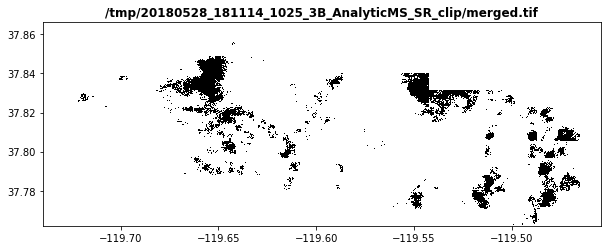

In [77]:
mask_file = os.path.join(destination.value, 'merged.tif').strip()
with rio.open(mask_file) as f:
    fig, ax = plt.subplots(figsize=(10,8))
    show(f, title=mask_file, cmap='binary', ax = ax)

In [78]:
print(destination.value)

/tmp/20180528_181114_1025_3B_AnalyticMS_SR_clip/
